# Text classification: We are going to developp a model able to classify text in 6 categories.

# Choose directories

In [ ]:
"""

data_path : concerns the path of the .csv file used as training set
models_folder : referes to the folder where the models obtain after each epochs will store.
main_folder : refers to folder containing your Train.csv file, the of Dataset folder that 
N_EPOCHS : is the number of iterations

"""

data_path = "drive/MyDrive/Dataset/text classification/Train.csv"
models_folder = "drive/MyDrive/Models/text classification/"
main_folder = "drive/MyDrive/Dataset/text classification/"
N_EPOCHS = 12

## Installation spacy==3.1.0 et fr_code_news_sm pour spacy

In [ ]:
%pip install bitarray fastBPE hydra-core omegaconf regex requests sacremoses subword_nmt gradio spacy==3.1.0
!python -m spacy download fr_core_news_sm

## Import

In [1]:
import os
import torch
from torchtext.legacy import data
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random


In [ ]:
# If you are usingcollab

from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.activity.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fexperimentsandconfigs%20https%3a%2f%2fwww.googleapis.com%2fauth%2fphotos.native&response_type=code

Enter your authorization code:
4/1AX4XfWhWa5qMwicAf1Ru3afYj80LPpj_OZZcbrfBZ7HGjsFTnSzAHz8g7zA


## Reproducibility

In [ ]:
SEED = 2021

def reproducibility(seed=2021):
    
    # seed for random, os, numpy and torch librayr
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    
    # seed fo cuda
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

reproducibility(SEED)

## EDA

In [ ]:
donnees = pd.read_csv(data_path, index_col="Tweet_ID")

sns.set_style("dark")
sns.set_context("notebook")
plt.figure(figsize=(8, 5))
plt.subplot(111)
sns.countplot(data=donnees, x="type")
plt.xticks(rotation=90)
plt.legend(loc="upper right")
plt.show()

In [ ]:
num_data_per_class = donnees["type"].value_counts()
num_data_per_class

In [ ]:
percentage_data_per_class = 100*donnees["type"].value_counts()/donnees.shape[0]
percentage_data_per_class

In [ ]:
1 / (100*donnees["type"].value_counts()/donnees.shape[0])

## Resampling

In [ ]:
labels = ["sexual_violence", "Physical_violence", "emotional_violence",
         "economic_violence", "Harmful_Traditional_practice"]

## For generate french dataset

In [ ]:
# Load an En-Fr Transformer model trained on WMT'14 data :
en2fr = torch.hub.load('pytorch/fairseq:v0.10.2', 'transformer.wmt14.en-fr', tokenizer='moses', bpe='subword_nmt')

# Use the GPU (optional):
en2fr.cuda()

In [ ]:
import math
percent = 0.7

new_train_data = pd.concat([donnees.loc[donnees["type"]==t, :].sample(130) for t in labels]
                , axis=0)

new_valid_data = pd.concat([donnees.loc[donnees["type"]==t, :].sample(58) for t in labels]
                , axis=0)

new_train_data["tweet"] = pd.DataFrame(new_train_data["tweet"].apply(lambda x:  en2fr.translate(x)))
new_valid_data["tweet"] = pd.DataFrame(new_valid_data["tweet"].apply(lambda x:  en2fr.translate(x)))

new_train_data.to_csv(main_folder+"new_train.csv")
new_valid_data.to_csv(main_folder+"new_valid.csv")

## Preprocessing

In [ ]:
# Now, let us see how to preprocess the text using field objects.
# There are 2 different types of field objects – Field and LabelField.
# Field concern the preprocessing tehcnics to apply on text ans LabelField concern ones toapply for Label.

TEXT = data.Field(tokenize='spacy', tokenizer_language='fr', batch_first=True, include_lengths=True)
LABEL = data.LabelField()

# This variable is used to read file data.
fields = [('Tweet_ID',None), ('tweet',TEXT), ('type', LABEL)]

# Loading custom dataset    
train_data=data.TabularDataset(path = 'drive/MyDrive/Dataset/text classification/new_train.csv'
                                  ,format = 'csv', fields = fields, skip_header = True)
valid_data=data.TabularDataset(path = 'drive/MyDrive/Dataset/text classification/new_valid.csv'
                                  ,format = 'csv', fields = fields, skip_header = True)

# Print preprocessed text
print(vars(train_data.examples[0]))

## Split data to train and validation set 

In [ ]:
# Check whether cuda is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  

# Set batch size
BATCH_SIZE = 64

# Load iterators
train_iterator, valid_iterator = data.BucketIterator.splits(
    (train_data, valid_data),
    batch_size = BATCH_SIZE,
    sort_key = lambda x: len(x.tweet),
    sort_within_batch=True,
    device = device)

## Preparing input and output sequences

In [ ]:
# Initialize glove embeddings
TEXT.build_vocab(train_data, min_freq=3, vectors = "glove.6B.100d")  
LABEL.build_vocab(train_data)

# No. of unique tokens in text
print("Size of TEXT vocabulary:",len(TEXT.vocab))

# No. of unique tokens in label
print("Size of LABEL vocabulary:",len(LABEL.vocab))

# Commonly used words
print("Commonly used words", TEXT.vocab.freqs.most_common(10))  

# Word dictionary
print("Word dictionary", TEXT.vocab.stoi.items())   

.vector_cache/glove.6B.zip: 862MB [02:41, 5.34MB/s]                           
100%|█████████▉| 399999/400000 [00:20<00:00, 19378.99it/s]


Size of TEXT vocabulary: 1135
Size of LABEL vocabulary: 5
Commonly used words [('.', 1039), (',', 870), ('de', 720), ('que', 486), ('et', 431), ('"', 376), ('à', 363), ('a', 349), ('me', 342), ('-', 327)]
Word dictionary dict_items([('<unk>', 0), ('<pad>', 1), ('.', 2), (',', 3), ('de', 4), ('que', 5), ('et', 6), ('"', 7), ('à', 8), ('a', 9), ('me', 10), ('-', 11), ('la', 12), ('je', 13), ('pas', 14), ('le', 15), ('des', 16), ('un', 17), ('ne', 18), ('une', 19), ('en', 20), ('les', 21), ('il', 22), ('mon', 23), ('pour', 24), ('été', 25), ("m'a", 26), ('Je', 27), ("qu'il", 28), ('qui', 29), ('parce', 30), ("j'ai", 31), ('femme', 32), ('vous', 33), ('dans', 34), ('I', 35), ("J'ai", 36), ('dit', 37), ('ce', 38), ('est', 39), ('public', 40), ('mari', 41), (':', 42), ('!', 43), ('au', 44), ('Il', 45), ('suis', 46), ('?', 47), ('mais', 48), ('avec', 49), ('...', 50), ('ans', 51), ('lui', 52), ('moi', 53), ('bat', 54), ('être', 55), ('comme', 56), ('si', 57), ('était', 58), ('plus', 59), ('so

In [12]:
help(TEXT.build_vocab)

Help on method build_vocab in module torchtext.legacy.data.field:

build_vocab(*args, **kwargs) method of torchtext.legacy.data.field.Field instance
    Construct the Vocab object for this field from one or more datasets.
    
    Arguments:
        Positional arguments: Dataset objects or other iterable data
            sources from which to construct the Vocab object that
            represents the set of possible values for this field. If
            a Dataset object is provided, all columns corresponding
            to this field are used; individual columns can also be
            provided directly.
        Remaining keyword arguments: Passed to the constructor of Vocab.



## Build the model

In [ ]:
import torch.nn as nn

class classifier(nn.Module):
    
    #define all the layers used in model
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, 
                 bidirectional, dropout):
        
        #Constructor
        super().__init__()          
        
        #embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        #lstm layer
        self.lstm = nn.LSTM(embedding_dim, 
                           hidden_dim, 
                           num_layers=n_layers, 
                           bidirectional=bidirectional, 
                           dropout=dropout,
                           batch_first=True)
        
        #dense layer
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        
        #activation function
        self.act = nn.Sigmoid()
        
    def forward(self, text, text_lengths):
        
        #text = [batch size,sent_length]
        embedded = self.embedding(text)
        #embedded = [batch size, sent_len, emb dim]
      
        #packed sequence
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths.to("cpu"), batch_first=True)
        
        packed_output, (hidden, cell) = self.lstm(packed_embedded)
        #hidden = [batch size, num layers * num directions,hid dim]
        #cell = [batch size, num layers * num directions,hid dim]
        
        #concat the final forward and backward hidden state
        hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)
                
        #hidden = [batch size, hid dim * num directions]
        dense_outputs=self.fc(hidden)

        #Final activation function
        outputs=self.act(dense_outputs)
        
        return outputs

In [ ]:
#define hyperparameters
size_of_vocab = len(TEXT.vocab)
embedding_dim = 100
num_hidden_nodes = 32
num_output_nodes = 5
num_layers = 2
bidirection = True
dropout = 0.2

#instantiate the model
model = classifier(size_of_vocab, embedding_dim, num_hidden_nodes,num_output_nodes, num_layers, 
                   bidirectional = True, dropout = dropout)

In [ ]:
#architecture
print(model)

#No. of trianable parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
    
print(f'The model has {count_parameters(model):,} trainable parameters')

#Initialize the pretrained embedding
pretrained_embeddings = TEXT.vocab.vectors
model.embedding.weight.data.copy_(pretrained_embeddings)

print(pretrained_embeddings.shape)

classifier(
  (embedding): Embedding(1135, 100)
  (lstm): LSTM(100, 32, num_layers=2, batch_first=True, dropout=0.2, bidirectional=True)
  (fc): Linear(in_features=64, out_features=5, bias=True)
  (act): Sigmoid()
)
The model has 173,217 trainable parameters
torch.Size([1135, 100])


In [ ]:
import torch.optim as optim

#define optimizer and loss
optimizer = optim.Adam(model.parameters())
criterion = nn.BCELoss()#weight=torch.tensor([0.012145, 0.066683, 0.609063, 1.827189, 2.109043])) 

#define metric
def binary_accuracy(preds, y):
    #round predictions to the closest integer
    rounded_preds = torch.round(preds)
    
    correct = (rounded_preds == y).float() 
    acc = correct.sum() / len(correct)
    return acc
    
#push to cuda if available
model = model.to(device)
criterion = criterion.to(device)

In [ ]:
def train(model, iterator, optimizer, criterion):
    
    #initialize every epoch 
    epoch_loss = 0
    epoch_acc = 0
    
    #set the model in training phase
    model.train()  
    
    for batch in iterator:
        
        #resets the gradients after every batch
        optimizer.zero_grad()   
        
        #retrieve text and no. of words
        text, text_lengths = batch.tweet   
        #convert to 1D tensor
        predictions = model(text, text_lengths)
        
        #compute the loss
        batch_size = batch.type.shape[0]
        target = torch.zeros((batch_size, num_output_nodes))
        target[[i for i in range(batch_size)], batch.type.to("cpu").numpy()] = 1.0
        target = target.to(device)
        
        loss = criterion(predictions, target)        
        
        #compute the binary accuracy
        #acc = binary_accuracy(predictions, batch.label)   
        
        #backpropage the loss and compute the gradients
        loss.backward()       
        
        #update the weights
        optimizer.step()      
        
        #loss and accuracy
        epoch_loss += loss.item()  
        #epoch_acc += acc.item()    
        
    return epoch_loss / len(iterator)#, epoch_acc / len(iterator)

In [ ]:
def evaluate(model, iterator, criterion):
    
    #initialize every epoch
    epoch_loss = 0
    epoch_acc = 0

    #deactivating dropout layers
    model.eval()
    
    #deactivates autograd
    with torch.no_grad():
    
        for batch in iterator:
        
            #retrieve text and no. of words
            text, text_lengths = batch.tweet
            
            #convert to 1d tensor
            predictions = model(text, text_lengths)
            
            #compute the loss
            batch_size = batch.type.shape[0]
            target = torch.zeros((batch_size, num_output_nodes))
            target[[i for i in range(batch_size)], batch.type.to("cpu").numpy()] = 1.0
            target = target.to(device)
            
            #compute loss and accuracy
            loss = criterion(predictions, target)        
            #acc = binary_accuracy(predictions, batch.label)
            
            #keep track of loss and accuracy
            epoch_loss += loss.item()
            #epoch_acc += acc.item()
        
    return epoch_loss / len(iterator)#, epoch_acc / len(iterator)

In [ ]:
best_valid_loss = float('inf')

train_loss = np.zeros((1, N_EPOCHS))
valid_loss = np.zeros((1, N_EPOCHS))

for epoch in range(N_EPOCHS):
     
    #train the model
    train_loss[0, epoch] = train(model, train_iterator, optimizer, criterion)
    
    #evaluate the model
    valid_loss[0, epoch] = evaluate(model, valid_iterator, criterion)
    
    #save the best model
    if valid_loss[0, epoch] < best_valid_loss:
        best_valid_loss = valid_loss[0, epoch]
        torch.save(model.state_dict(), models_folder+'saved_weights('+str(epoch)+').pt')
    
    print(f"EPOCH {epoch}%")
    print(f'\tTrain Loss: {train_loss[0, epoch]:.3f}%')# | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss[0, epoch]:.3f}%')# |  Val. Acc: {valid_acc*100:.2f}%')


EPOCH 0%
	Train Loss: 0.330%
	 Val. Loss: 0.356%
EPOCH 1%
	Train Loss: 0.292%
	 Val. Loss: 0.339%
EPOCH 2%
	Train Loss: 0.263%
	 Val. Loss: 0.313%
EPOCH 3%
	Train Loss: 0.233%
	 Val. Loss: 0.286%
EPOCH 4%
	Train Loss: 0.212%
	 Val. Loss: 0.276%
EPOCH 5%
	Train Loss: 0.199%
	 Val. Loss: 0.264%
EPOCH 6%
	Train Loss: 0.184%
	 Val. Loss: 0.248%
EPOCH 7%
	Train Loss: 0.186%
	 Val. Loss: 0.251%
EPOCH 8%
	Train Loss: 0.159%
	 Val. Loss: 0.257%
EPOCH 9%
	Train Loss: 0.154%
	 Val. Loss: 0.266%
EPOCH 10%
	Train Loss: 0.144%
	 Val. Loss: 0.252%
EPOCH 11%
	Train Loss: 0.147%
	 Val. Loss: 0.217%


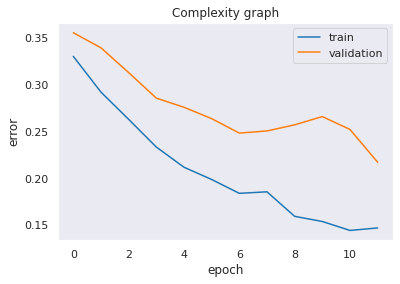

In [ ]:
# Plot the complexity graph
plt.plot(train_loss[0,:], label = "train")
plt.plot(valid_loss[0,:], label = "validation")
plt.xlabel('epoch')
# Set the y axis label of the current axis.
plt.ylabel('error')
# Set a title of the current axes.
plt.title('Complexity graph')
# show a legend on the plot
plt.legend()
# Display a figure.
plt.show()

In [ ]:
#load weights
path=models_folder+'saved_weights('+str(N_EPOCH-1)+').pt'
model.load_state_dict(torch.load(path));
model.eval();

#inference 
import spacy
nlp = spacy.load("fr_core_news_sm")

CLASS = ["Sexual violence", "Physical violence", "Emotional Violence",
         "Economic Violence", "Harmful traditional practice"]

def predict(sentence):
    tokenized = [tok.text for tok in nlp.tokenizer(sentence)]  #tokenize the sentence 
    indexed = [TEXT.vocab.stoi[t] for t in tokenized]          #convert to integer sequence
    
    length = len(indexed)
    length_tensor = torch.LongTensor([length]).to('cpu')
    
    my_tensor = torch.LongTensor(indexed).to(device)           #convert to tensor
    my_tensor = torch.reshape(my_tensor, (1, length))          #reshape in form of batch,no. of words
    
    prediction = model(my_tensor, length_tensor)               #prediction 
    i = prediction.argmax().to('cpu').numpy()
    
    return CLASS[i]

In [ ]:
# make predictions
predict("IL m'a oubligé à coucher avec lui")

'Physical violence'